In [1]:
import sys
sys.path.insert(0, '../')

import pandas as pd
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix
import matplotlib.pyplot as plt
import os
from collections import Counter
%matplotlib notebook

Using TensorFlow backend.


In [2]:
import torch.nn as nn
import torch.nn.functional as F

## original
# class Net(nn.Module):
#     def __init__(self,):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 32, 9)
#         self.pool = nn.MaxPool2d(25, 17)
#         self.norm = nn.BatchNorm2d(32)
#         self.fc1 = nn.Linear(4608, 32)
#         self.dropout = nn.Dropout2d(p=0.2)
#         self.fc2 = nn.Linear(32, 32)
#         self.fc3 = nn.Linear(32,50)
#         self.softmax = nn.Softmax()

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.norm(x)
#         x = F.relu(x)
#         x = self.pool(x)
#         x = x.view(x.shape[0], -1)
#         x = self.fc1(x)
#         x = F.relu(x)
#         x = self.fc2(x)
#         x = F.relu(x)
#         x = self.dropout(x)
#         x = self.fc2(x)
#         x = F.relu(x)
#         x = self.fc2(x)
#         x = F.relu(x)
#         x = self.dropout(x)
#         x = self.fc3(x)
#         x = self.softmax(x)
#         return x

#learn faster 
# class Net(nn.Module):
#     def __init__(self,):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 32, 9)
#         self.conv2 = nn.Conv2d(32, 32, 5)
#         self.norm = nn.BatchNorm2d(32)
#         self.pool = nn.MaxPool2d(7, 7)
#         self.fc1 = nn.Linear(256, 128)
#         self.dropout = nn.Dropout2d(p=0.2)
# #         self.fc2 = nn.Linear(256, 128)
#         self.fc3 = nn.Linear(128,64)
#         self.fc4 = nn.Linear(64,50)
#         self.softmax = nn.Softmax()

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.norm(x)
#         x = F.relu(x)
#         x = self.pool(x)
#         x = self.conv2(x)
#         x = self.norm(x)
#         x = F.relu(x)
#         x = self.pool(x)
#         x = x.view(x.shape[0], -1)
#         x = self.fc1(x)
#         x = F.relu(x)
# #         x = self.fc2(x)
# #         x = F.relu(x)
#         x = self.dropout(x)
#         x = self.fc3(x)
#         x = F.relu(x)
#         x = self.dropout(x)
#         x = self.fc4(x)
#         x = self.softmax(x)
#         return x
    
    
class Net(nn.Module):
    def __init__(self,):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, (3,6))
        self.norm1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(3, 6)
        self.conv2 = nn.Conv2d(64, 32, (3,6))
        self.norm2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(3, 6)
        self.conv3 = nn.Conv2d(32, 32, (3,6))
        self.norm3 = nn.BatchNorm2d(32)
        self.pool3 = nn.MaxPool2d(3,6)
        
        self.fc1 = nn.Linear(192, 50)
        self.dropout = nn.Dropout2d(p=0.2)
        self.fc2 = nn.Linear(64, 50)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.norm3(x)
        x = F.relu(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
#         x = F.relu(x)
#         x = self.fc2(x)
        x = self.softmax(x)
        return x

In [3]:
# load data:
from PIL import Image
import os 
import numpy as np
from torch.utils.data import Dataset, DataLoader

class trainset(Dataset):
    def __init__(self):
        
        root = "./data2/"
        self.data_list = []
        self.label_list = []
        for root, dir, files in os.walk("./data2/"):
            for file in files:
                if file.find('.npy')!= -1:
                    self.data_list.append(os.path.join(root, file))
                    self.label_list.append(int(root[13:]))
        print(len(self.data_list), len(self.label_list))
        
    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, index):

        path = self.data_list[index]
#         print(path)
#         data = []
#         label = []
        data = np.load(path,allow_pickle = True)
        data = np.expand_dims(data, axis=0)
#         data = np.asarray(Image.open(path))
        label= self.label_list[index] 
#         print(data.shape)
#         data = np.asarray(data)
        label = np.asarray(label)
        
        return data, label
dataloader = trainset()
data,label = dataloader.__getitem__(5)
# print(label.shape)
print(data.shape, label.shape)

2000 2000
(1, 128, 431) ()


In [13]:
import torch.optim as optim
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import time

from torch.optim.lr_scheduler import StepLR


# model = BaseNet()
model = Net()
model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0005)
scheduler = StepLR(optimizer, step_size=15, gamma=0.8)

validation_split = .2
random_seed= 42
shuffle_dataset = True
dataset_size = 2000
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

dataset  = trainset()
trainloader = torch.utils.data.DataLoader(dataset, batch_size=64, 
                                           sampler=train_sampler)
valloader = torch.utils.data.DataLoader(dataset, batch_size=64,
                                                sampler=valid_sampler)

val_history = []
val_loss_hist = []
train_history = []
train_loss_hist = []

for epoch in range(100):  # loop over the dataset multiple times
    
########## Validation ###########
    
    count = 0
    running_accuracy = 0
    running_loss = 0
    t1 = time.time()
    for i, data in enumerate(valloader, 0):
        count += 1
        inputs, labels = data
        inputs = inputs.float()
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = model(inputs)
        val_loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        acc_val = torch.eq(preds, labels).float().mean()
        running_accuracy += acc_val.item()
        running_loss += val_loss.item()
        
    running_accuracy /= count
    running_loss /= count
    val_history.append(running_accuracy)
    val_loss_hist.append(running_loss)
    t2 = time.time()
    print("===========Phase: Val============")
    print("Validation Time: {}".format(t2 - t1))
    print("Epoch: {}  val_loss: {}".format(epoch, running_loss))
    print("Epoch: {}  val_accuracy: {}".format(epoch, running_accuracy))
    
######### Training ###########   
    
    running_loss = 0.0
    count = 0
    training_accuracy = 0
    t1 = time.time()
    for i, data in enumerate(trainloader, 0):
        count += 1
        inputs, labels = data
        inputs = inputs.float()
        inputs = inputs.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        acc_train = torch.eq(preds, labels).float().mean()
        running_accuracy += acc_train.item()
        
    scheduler.step()
    running_accuracy /= count
    running_loss /= count
    train_history.append(running_accuracy)
    train_loss_hist.append(running_loss)
    t2 = time.time()
    print("===========Phase: Train============") 
    print("Training Time: {}".format(t2 - t1))
    print("Epoch: {}  train_loss: {}".format(epoch, running_loss))
    print("Epoch: {}  train_accuracy: {}".format(epoch, running_accuracy))
    print()
        
# # #             torch.save(net, 'toy_model.pt')
        
    
print('Finished Training')


2000 2000


/root/anaconda3/envs/netdissect/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


===========Phase: Val============
Validation Time: 0.9584507942199707
Epoch: 0  val_loss: 3.912390981401716
Epoch: 0  val_accuracy: 0.017857142857142856
===========Phase: Train============
Training Time: 7.432716131210327
Epoch: 0  train_loss: 3.898827323913574
Epoch: 0  train_accuracy: 0.06571428571428571

===========Phase: Val============
Validation Time: 0.8893847465515137
Epoch: 1  val_loss: 3.89316531590053
Epoch: 1  val_accuracy: 0.05357142857142857
===========Phase: Train============
Training Time: 7.432270765304565
Epoch: 1  train_loss: 3.8676191329956056
Epoch: 1  train_accuracy: 0.08839285714285715

===========Phase: Val============
Validation Time: 0.8871731758117676
Epoch: 2  val_loss: 3.8778198787144254
Epoch: 2  val_accuracy: 0.0625
===========Phase: Train============
Training Time: 7.436594247817993
Epoch: 2  train_loss: 3.845473690032959
Epoch: 2  train_accuracy: 0.11625

===========Phase: Val============
Validation Time: 0.8880879878997803
Epoch: 3  val_loss: 3.8662254

===========Phase: Val============
Validation Time: 0.8895053863525391
Epoch: 27  val_loss: 3.6263370173318044
Epoch: 27  val_accuracy: 0.36607142857142855
===========Phase: Train============
Training Time: 7.554772853851318
Epoch: 27  train_loss: 3.350638360977173
Epoch: 27  train_accuracy: 0.6571428571428573

===========Phase: Val============
Validation Time: 0.8894238471984863
Epoch: 28  val_loss: 3.6153463295527866
Epoch: 28  val_accuracy: 0.38392857142857145
===========Phase: Train============
Training Time: 7.435641765594482
Epoch: 28  train_loss: 3.3357616424560548
Epoch: 28  train_accuracy: 0.6703571428571428

===========Phase: Val============
Validation Time: 0.8914763927459717
Epoch: 29  val_loss: 3.6178723743983676
Epoch: 29  val_accuracy: 0.37723214285714285
===========Phase: Train============
Training Time: 7.4488914012908936
Epoch: 29  train_loss: 3.3203867435455323
Epoch: 29  train_accuracy: 0.6819642857142857

===========Phase: Val============
Validation Time: 0.89214706

===========Phase: Val============
Validation Time: 0.8911774158477783
Epoch: 54  val_loss: 3.60783280645098
Epoch: 54  val_accuracy: 0.39955357142857145
===========Phase: Train============
Training Time: 7.438426494598389
Epoch: 54  train_loss: 3.1116712856292725
Epoch: 54  train_accuracy: 0.8753571428571427

===========Phase: Val============
Validation Time: 0.8939905166625977
Epoch: 55  val_loss: 3.602754899433681
Epoch: 55  val_accuracy: 0.38839285714285715
===========Phase: Train============
Training Time: 7.4526872634887695
Epoch: 55  train_loss: 3.10581597328186
Epoch: 55  train_accuracy: 0.8761607142857143

===========Phase: Val============
Validation Time: 0.890308141708374
Epoch: 56  val_loss: 3.6103431837899342
Epoch: 56  val_accuracy: 0.39732142857142855
===========Phase: Train============
Training Time: 7.442348480224609
Epoch: 56  train_loss: 3.102257251739502
Epoch: 56  train_accuracy: 0.8802678571428573

===========Phase: Val============
Validation Time: 0.88495492935180

===========Phase: Val============
Validation Time: 0.8884434700012207
Epoch: 81  val_loss: 3.604358741215297
Epoch: 81  val_accuracy: 0.39285714285714285
===========Phase: Train============
Training Time: 7.448935270309448
Epoch: 81  train_loss: 3.0136320781707764
Epoch: 81  train_accuracy: 0.9588392857142857

===========Phase: Val============
Validation Time: 0.8913564682006836
Epoch: 82  val_loss: 3.5970797879355296
Epoch: 82  val_accuracy: 0.390625
===========Phase: Train============
Training Time: 7.4419004917144775
Epoch: 82  train_loss: 3.011708068847656
Epoch: 82  train_accuracy: 0.95875

===========Phase: Val============
Validation Time: 0.8905198574066162
Epoch: 83  val_loss: 3.6261215891156877
Epoch: 83  val_accuracy: 0.37723214285714285
===========Phase: Train============
Training Time: 7.458951950073242
Epoch: 83  train_loss: 3.0109971714019776
Epoch: 83  train_accuracy: 0.9582142857142857

===========Phase: Val============
Validation Time: 0.8950357437133789
Epoch: 84  val

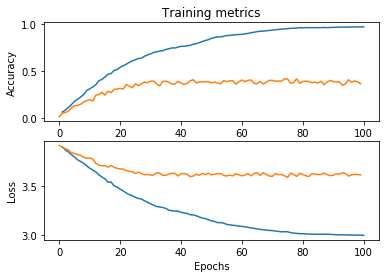

In [14]:
x_axis = np.linspace(1,100,100)
plt.subplot(2, 1, 1)
plt.plot(x_axis, train_history, val_history)
plt.title('Training metrics')
plt.ylabel('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(x_axis, train_loss_hist, val_loss_hist)
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [15]:
import torch.optim as optim
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import time

from torch.optim.lr_scheduler import StepLR


# model = BaseNet()
model = Net()
model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0005)
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

validation_split = .2
random_seed= 42
shuffle_dataset = True
dataset_size = 2000
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

dataset  = trainset()
trainloader = torch.utils.data.DataLoader(dataset, batch_size=64, 
                                           sampler=train_sampler)
valloader = torch.utils.data.DataLoader(dataset, batch_size=64,
                                                sampler=valid_sampler)

val_history = []
val_loss_hist = []
train_history = []
train_loss_hist = []

for epoch in range(100):  # loop over the dataset multiple times
    
########## Validation ###########
    
    count = 0
    running_accuracy = 0
    running_loss = 0
    t1 = time.time()
    for i, data in enumerate(valloader, 0):
        count += 1
        inputs, labels = data
        inputs = inputs.float()
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = model(inputs)
        val_loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        acc_val = torch.eq(preds, labels).float().mean()
        running_accuracy += acc_val.item()
        running_loss += val_loss.item()
        
    running_accuracy /= count
    running_loss /= count
    val_history.append(running_accuracy)
    val_loss_hist.append(running_loss)
    t2 = time.time()
    print("===========Phase: Val============")
    print("Validation Time: {}".format(t2 - t1))
    print("Epoch: {}  val_loss: {}".format(epoch, running_loss))
    print("Epoch: {}  val_accuracy: {}".format(epoch, running_accuracy))
    
######### Training ###########   
    
    running_loss = 0.0
    count = 0
    training_accuracy = 0
    t1 = time.time()
    for i, data in enumerate(trainloader, 0):
        count += 1
        inputs, labels = data
        inputs = inputs.float()
        inputs = inputs.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        acc_train = torch.eq(preds, labels).float().mean()
        running_accuracy += acc_train.item()
        
    scheduler.step()
    running_accuracy /= count
    running_loss /= count
    train_history.append(running_accuracy)
    train_loss_hist.append(running_loss)
    t2 = time.time()
    print("===========Phase: Train============") 
    print("Training Time: {}".format(t2 - t1))
    print("Epoch: {}  train_loss: {}".format(epoch, running_loss))
    print("Epoch: {}  train_accuracy: {}".format(epoch, running_accuracy))
    print()
        
# # #             torch.save(net, 'toy_model.pt')
        
    
print('Finished Training')


2000 2000


/root/anaconda3/envs/netdissect/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


===========Phase: Val============
Validation Time: 0.9640359878540039
Epoch: 0  val_loss: 3.912670544215611
Epoch: 0  val_accuracy: 0.011160714285714286
===========Phase: Train============
Training Time: 7.433197259902954
Epoch: 0  train_loss: 3.904611892700195
Epoch: 0  train_accuracy: 0.054821428571428577

===========Phase: Val============
Validation Time: 0.8911974430084229
Epoch: 1  val_loss: 3.896448407854353
Epoch: 1  val_accuracy: 0.049107142857142856
===========Phase: Train============
Training Time: 7.439900875091553
Epoch: 1  train_loss: 3.8784398365020754
Epoch: 1  train_accuracy: 0.08008928571428571

===========Phase: Val============
Validation Time: 0.8887996673583984
Epoch: 2  val_loss: 3.879129409790039
Epoch: 2  val_accuracy: 0.05357142857142857
===========Phase: Train============
Training Time: 7.425055265426636
Epoch: 2  train_loss: 3.85243013381958
Epoch: 2  train_accuracy: 0.09089285714285715

===========Phase: Val============
Validation Time: 0.8891000747680664
Epo

===========Phase: Train============
Training Time: 7.429378271102905
Epoch: 26  train_loss: 3.359272756576538
Epoch: 26  train_accuracy: 0.6497321428571428

===========Phase: Val============
Validation Time: 0.8925189971923828
Epoch: 27  val_loss: 3.6510374205453053
Epoch: 27  val_accuracy: 0.35267857142857145
===========Phase: Train============
Training Time: 7.43943977355957
Epoch: 27  train_loss: 3.3483800411224367
Epoch: 27  train_accuracy: 0.6572321428571428

===========Phase: Val============
Validation Time: 0.8861477375030518
Epoch: 28  val_loss: 3.6487605231148854
Epoch: 28  val_accuracy: 0.34598214285714285
===========Phase: Train============
Training Time: 7.449365615844727
Epoch: 28  train_loss: 3.339773836135864
Epoch: 28  train_accuracy: 0.6619642857142857

===========Phase: Val============
Validation Time: 0.8888237476348877
Epoch: 29  val_loss: 3.6387601920536587
Epoch: 29  val_accuracy: 0.3482142857142857
===========Phase: Train============
Training Time: 7.434279680252

===========Phase: Val============
Validation Time: 0.8919575214385986
Epoch: 53  val_loss: 3.6179723739624023
Epoch: 53  val_accuracy: 0.39285714285714285
===========Phase: Train============
Training Time: 7.44671106338501
Epoch: 53  train_loss: 3.1909408569335938
Epoch: 53  train_accuracy: 0.8007142857142857

===========Phase: Val============
Validation Time: 0.892357349395752
Epoch: 54  val_loss: 3.5933916909354076
Epoch: 54  val_accuracy: 0.4174107142857143
===========Phase: Train============
Training Time: 7.4458699226379395
Epoch: 54  train_loss: 3.191685609817505
Epoch: 54  train_accuracy: 0.8029464285714286

===========Phase: Val============
Validation Time: 0.8910832405090332
Epoch: 55  val_loss: 3.6156342029571533
Epoch: 55  val_accuracy: 0.375
===========Phase: Train============
Training Time: 7.452276706695557
Epoch: 55  train_loss: 3.1809303092956545
Epoch: 55  train_accuracy: 0.814375

===========Phase: Val============
Validation Time: 0.8898799419403076
Epoch: 56  val_los

===========Phase: Val============
Validation Time: 0.8944587707519531
Epoch: 80  val_loss: 3.5930672713688443
Epoch: 80  val_accuracy: 0.40401785714285715
===========Phase: Train============
Training Time: 7.443511009216309
Epoch: 80  train_loss: 3.1083222007751465
Epoch: 80  train_accuracy: 0.8799107142857143

===========Phase: Val============
Validation Time: 0.8885858058929443
Epoch: 81  val_loss: 3.6099612031664168
Epoch: 81  val_accuracy: 0.37723214285714285
===========Phase: Train============
Training Time: 7.438722848892212
Epoch: 81  train_loss: 3.1077304744720458
Epoch: 81  train_accuracy: 0.8800892857142857

===========Phase: Val============
Validation Time: 0.8929438591003418
Epoch: 82  val_loss: 3.6133226667131697
Epoch: 82  val_accuracy: 0.38169642857142855
===========Phase: Train============
Training Time: 7.4517388343811035
Epoch: 82  train_loss: 3.1046731281280517
Epoch: 82  train_accuracy: 0.8827678571428572

===========Phase: Val============
Validation Time: 0.8964974

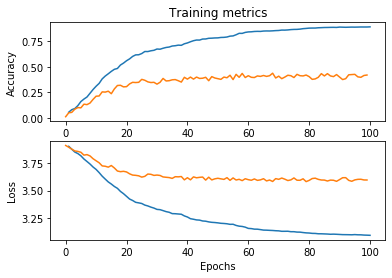

In [16]:
x_axis = np.linspace(1,100,100)
plt.subplot(2, 1, 1)
plt.plot(x_axis, train_history, val_history)
plt.title('Training metrics')
plt.ylabel('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(x_axis, train_loss_hist, val_loss_hist)
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [22]:
torch.save(net, './model_v0.pt')

/root/anaconda3/envs/netdissect/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
